In [86]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

from utils import convert_to_PCS_circ, convert_to_PCS_circ_largest_clifford
from pauli_checks import (ChecksFinder, add_pauli_checks, add_meas_pauli_checks, add_linear_meas_pauli_checks,  search_for_pauli_list,
gen_initial_layout, gen_final_layout, complete_postprocess, filter_results,
postselect_counts)

### Generate VQE circuit

In [87]:
import numpy as np

from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit import transpile

In [88]:
def hydrogen_trial_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    # prepare the Hartree-Fock state
    qc.x(0)
    qc.x(1)
    
    qc.rx(np.pi/2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)

    # qc.barrier()
    qc.cx(0,1)
    qc.cx(1,2)
    qc.cx(2,3)
    # qc.barrier()
    
    qc.rz(1.0, 3)
    
    qc.cx(2,3)
    qc.cx(1,2)
    qc.cx(0,1)
    
    qc.rx(-np.pi/2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    
    return qc

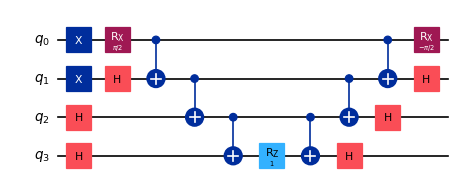

In [89]:
circ = hydrogen_trial_circuit(4)
circ.draw("mpl", scale=0.6)

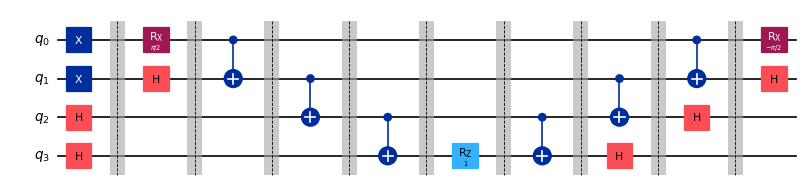

In [90]:
from qiskit_addon_utils.slicing import combine_slices, slice_by_depth

slices = slice_by_depth(circ, 1)
combined_slices = combine_slices(slices, include_barriers=True)
combined_slices.draw("mpl", scale=0.6)

### Add PCS protection on largest clifford

In [91]:
num_qubits = 4
num_checks = 2

sign_list, pcs_circ = convert_to_PCS_circ_largest_clifford(circ, num_qubits, num_checks)

Largest Clifford block is from slice 6 to 8.
Found check 1: +1XXXX, +1IIIX
Found check 2: +1IIIZ, +1IIIZ
Required number of checks found.
p1_list =  [['+1XXXX', '+1IIIX'], ['+1IIIZ', '+1IIIZ']]


['+1', '+1']


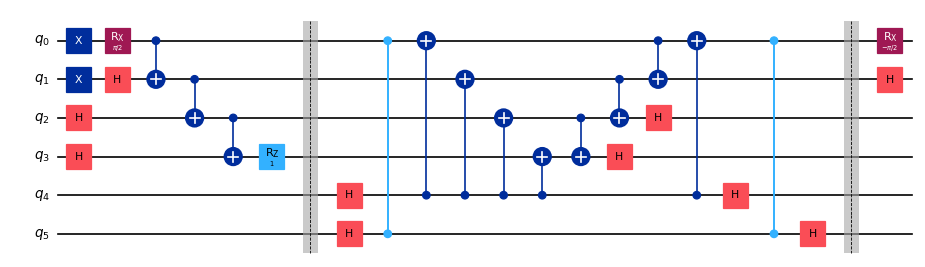

In [92]:
print(sign_list)
pcs_circ.draw("mpl", scale=0.6, fold=-1)

# Simulating

In [93]:
from qiskit_aer.primitives import SamplerV2 as sampler
from qiskit_aer.noise import NoiseModel, depolarizing_error
#from qiskit_ibm_runtime import SamplerV2 as sampler

basis_gates=["cx", "h", "rz", "rx", "x"]
noise_model = NoiseModel()
single_qubit_depolarizing_prob=0.001
cx_depolarizing_prob = 10*single_qubit_depolarizing_prob
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(single_qubit_depolarizing_prob, 1), ["h", "rz", "rx", "x"]
)

noisy_sampler = sampler(options={"backend_options": {"noise_model":noise_model}})
ideal_sampler = sampler()

In [94]:
circ.measure_all()
pcs_circ.measure_all()
pcs_circ =transpile(pcs_circ, basis_gates=basis_gates, optimization_level=1)
noisy_job_result = noisy_sampler.run([pcs_circ, circ], shots=1000).result()
pcs_circ_counts = noisy_job_result[0].data.meas.get_counts()
noisy_circ_counts=noisy_job_result[1].data.meas.get_counts()
ideal_job_result = ideal_sampler.run([circ], shots=1000).result()
ideal_circ_counts=ideal_job_result[0].data.meas.get_counts()
postselected_counts=postselect_counts(pcs_circ_counts, num_ancillas=2)
print(pcs_circ_counts)
print(postselected_counts)

{'001100': 193, '000011': 694, '011101': 2, '110010': 12, '111101': 2, '001111': 2, '101100': 4, '100011': 6, '000000': 9, '000001': 4, '000010': 6, '011100': 6, '001110': 2, '001101': 3, '000100': 8, '000111': 5, '001011': 7, '010011': 5, '010000': 4, '010100': 3, '010010': 4, '011011': 1, '001000': 1, '100101': 1, '111111': 1, '100010': 5, '100000': 1, '110001': 1, '101001': 1, '111100': 1, '101010': 1, '110110': 1, '110011': 4}
{'1100': 193, '0011': 694, '1111': 2, '0000': 9, '0001': 4, '0010': 6, '1110': 2, '1101': 3, '0100': 8, '0111': 5, '1011': 7, '1000': 1}


In [95]:
from qiskit.quantum_info import hellinger_fidelity

raw_fidelity=hellinger_fidelity(ideal_circ_counts, noisy_circ_counts)
mitigated_fidelity=hellinger_fidelity(ideal_circ_counts, postselected_counts)
postselection_rate=sum(postselected_counts.values())/sum(pcs_circ_counts.values())
print(f"raw fidelity: {raw_fidelity}")
print(f"mitigated fidelity: {mitigated_fidelity}")
print(f"postselection rate: {postselection_rate}")

raw fidelity: 0.9665044797872334
mitigated fidelity: 0.9487454441988912
postselection rate: 0.934
